<a href="https://colab.research.google.com/github/aidiel97/botnet/blob/main/BotnetDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Kebutuhan**

In [112]:
"""Writen By: M. Aidiel Rachman Putra & Winda Ayu Safitri"""
"""Organization: Net-Centic Computing Laboratory | Institut Teknologi Sepuluh Nopember"""

import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import socket, struct

from numpy import mean
from numpy import std

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [113]:
#dibutuhkan saat dataset berada pada GDrive
# from google.colab import drive
# drive.mount('/content/drive')

# **2. Memuat Dataset**

In [159]:
#koleksi seluruh skenario pada dataset CTU-13
ctuDatasets = {
  'scenario1': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/detailed-bidirectional-flow-labels/capture20110810.binetflow',
  'scenario2': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/detailed-bidirectional-flow-labels/capture20110811.binetflow',
  'scenario3': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-44/detailed-bidirectional-flow-labels/capture20110812.binetflow',
  'scenario4': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-45/detailed-bidirectional-flow-labels/capture20110815.binetflow',
  'scenario5': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-46/detailed-bidirectional-flow-labels/capture20110815-2.binetflow',
  'scenario6': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-47/detailed-bidirectional-flow-labels/capture20110816.binetflow',
  'scenario7': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-48/detailed-bidirectional-flow-labels/capture20110816-2.binetflow',
  'scenario8': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-49/detailed-bidirectional-flow-labels/capture20110816-3.binetflow',
  'scenario9': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-50/detailed-bidirectional-flow-labels/capture20110817.binetflow',
  'scenario10': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/detailed-bidirectional-flow-labels/capture20110818.binetflow',
  'scenario11': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-52/detailed-bidirectional-flow-labels/capture20110818-2.binetflow',
  'scenario12': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-53/detailed-bidirectional-flow-labels/capture20110819.binetflow',
  'scenario13': 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-54/detailed-bidirectional-flow-labels/capture20110815-3.binetflow',
}

In [160]:
# fileName = 'drive/My Drive/dataset_result_skenario11.csv' #load dataset on drive
fileName = ctuDatasets['scenario11'] #load dataset on CTU-stratosphereips
df=pd.read_csv(fileName)

# **3. Explorasi Data**

In [83]:
df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 15:39:35.087798,83.062141,tcp,147.32.84.202,1078,<?>,65.54.89.106,80,RPA_FPA,0.0,0.0,43065,40974671,1033777,flow=Background
1,2011/08/18 15:39:35.087915,497.720459,tcp,88.100.184.137,13121,<?>,147.32.85.26,62860,RPA_PA,0.0,0.0,326962,132430976,7076046,flow=Background
2,2011/08/18 15:39:35.091007,971.288147,tcp,147.32.84.2,80,<?>,218.75.208.58,3088,PA_A,0.0,0.0,7912,7356876,7153650,flow=Background
3,2011/08/18 15:39:35.091585,899.996399,tcp,90.181.84.58,54518,<?>,147.32.84.19,993,PA_PA,0.0,0.0,48,5728,3008,flow=Background
4,2011/08/18 15:39:35.093493,38.753445,tcp,147.32.86.116,19083,?>,151.82.9.107,2185,RPA_,0.0,NaN,7,456,456,flow=Background


In [84]:
print('Dimensi dari Dataset:',df.shape)

Dimensi dari Dataset: (107251, 15)


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107251 entries, 0 to 107250
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   StartTime  107251 non-null  object 
 1   Dur        107251 non-null  float64
 2   Proto      107251 non-null  object 
 3   SrcAddr    107251 non-null  object 
 4   Sport      106788 non-null  object 
 5   Dir        107251 non-null  object 
 6   DstAddr    107251 non-null  object 
 7   Dport      99351 non-null   object 
 8   State      107160 non-null  object 
 9   sTos       106271 non-null  float64
 10  dTos       90292 non-null   float64
 11  TotPkts    107251 non-null  int64  
 12  TotBytes   107251 non-null  int64  
 13  SrcBytes   107251 non-null  int64  
 14  Label      107251 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 12.3+ MB


## 3.1. Korelasi antar fitur


In [86]:
#correlation heatmap (Function)
def corrHeatmap(title, botnetDataframe):
  corr=botnetDataframe.corr()
  plt.figure()

  sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
  plt.title(title)

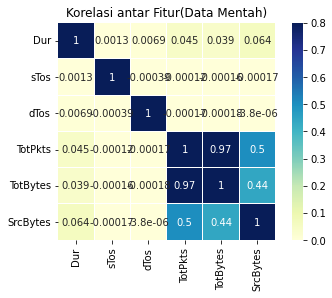

In [87]:
corrHeatmap('Korelasi antar Fitur(Data Mentah)', df)

## 3.2. Missing Value/Null Value

In [88]:
#counter precentage missing value in dataset (Function)
def missingValue(dataFrame):
    total = dataFrame.isnull().sum().sort_values(ascending = False)
    Percentage = (dataFrame.isnull().sum()/dataFrame.isnull().count()*100).sort_values(ascending = False)
    Dtypes =dataFrame.dtypes
    return pd.concat([total, Percentage,Dtypes], axis=1, keys=['Total', 'Percentage','Dtypes'])

In [89]:
missingValue(df).style.set_properties(**{"background-color": "#f6e58d"})

,Total,Percentage,Dtypes
dTos,16959,15.812440,float64
Dport,7900,7.365899,object
sTos,980,0.913744,float64
Sport,463,0.431698,object
State,91,0.084848,object
StartTime,0,0.000000,object
Dur,0,0.000000,float64
Proto,0,0.000000,object
SrcAddr,0,0.000000,object
Dir,0,0.000000,object


## 3.3. Fitur Kategorikal

In [90]:
#count categorical feature
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O']
print(categorical_features)

['StartTime', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'Label']


In [91]:
#value variation
for feature in categorical_features:
    print('In feature ==| {} |==, number of categories are | {} |.'.format(feature,len(df[feature].unique())))

In feature ==| StartTime |==, number of categories are | 107251 |.
In feature ==| Proto |==, number of categories are | 13 |.
In feature ==| SrcAddr |==, number of categories are | 29157 |.
In feature ==| Sport |==, number of categories are | 48457 |.
In feature ==| Dir |==, number of categories are | 6 |.
In feature ==| DstAddr |==, number of categories are | 15159 |.
In feature ==| Dport |==, number of categories are | 12505 |.
In feature ==| State |==, number of categories are | 176 |.
In feature ==| Label |==, number of categories are | 58 |.


# **4. Pra Pemrosesan Data (Pre Processing)**

## 4.1. Transformasi Data

### *4.1.1. [Label] Konversi Fitur Target kedalam binary*

In [143]:
reExp = r'^(?=.*?Botnet).*'
df['Label'] = np.where(df['Label'] == reExp, 1,0) #setiap label yang memiliki kata "botnet" akan diubah menjadi 1, selain itu 0

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107251 entries, 0 to 107250
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   StartTime  107251 non-null  object 
 1   Dur        107251 non-null  float64
 2   Proto      107251 non-null  object 
 3   SrcAddr    107251 non-null  object 
 4   Sport      106788 non-null  object 
 5   Dir        107251 non-null  object 
 6   DstAddr    107251 non-null  object 
 7   Dport      99351 non-null   object 
 8   State      107160 non-null  object 
 9   sTos       106271 non-null  float64
 10  dTos       90292 non-null   float64
 11  TotPkts    107251 non-null  int64  
 12  TotBytes   107251 non-null  int64  
 13  SrcBytes   107251 non-null  int64  
 14  Label      107251 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 12.3+ MB


### 4.1.2 [Kategorikal]  State (Python Dictionary)===================================

In [144]:
#state dictionary (source: Nagabhushan S Baddi)
stateDict = {'': 1, 'FSR_SA': 30, '_FSA': 296, 'FSRPA_FSA': 77, 'SPA_SA': 31, 'FSA_SRA': 1181, 'FPA_R': 46, 'SPAC_SPA': 37, 'FPAC_FPA': 2, '_R': 1, 'FPA_FPA': 784, 'FPA_FA': 66, '_FSRPA': 1, 'URFIL': 431, 'FRPA_PA': 5, '_RA': 2, 'SA_A': 2, 'SA_RA': 125, 'FA_FPA': 17, 'FA_RA': 14, 'PA_FPA': 48, 'URHPRO': 380, 'FSRPA_SRA': 8, 'R_':541, 'DCE': 5, 'SA_R': 1674, 'SA_': 4295, 'RPA_FSPA': 4, 'FA_A': 17, 'FSPA_FSPAC': 7, 'RA_': 2230, 'FSRPA_SA': 255, 'NNS': 47, 'SRPA_FSPAC': 1, 'RPA_FPA': 42, 'FRA_R': 10, 'FSPAC_FSPA': 86, 'RPA_R': 3, '_FPA': 5, 'SREC_SA': 1, 'URN': 339, 'URO': 6, 'URH': 3593, 'MRQ': 4, 'SR_FSA': 1, 'SPA_SRPAC': 1, 'URP': 23598, 'RPA_A': 1, 'FRA_': 351, 'FSPA_SRA': 91, 'FSA_FSA': 26138, 'PA_': 149, 'FSRA_FSPA': 798, 'FSPAC_FSA': 11, 'SRPA_SRPA': 176, 'SA_SA': 33, 'FSPAC_SPA': 1, 'SRA_RA': 78, 'RPAC_PA': 1, 'FRPA_R': 1, 'SPA_SPA': 2989, 'PA_RA': 3, 'SPA_SRPA': 4185, 'RA_FA': 8, 'FSPAC_SRPA': 1, 'SPA_FSA': 1, 'FPA_FSRPA': 3, 'SRPA_FSA': 379, 'FPA_FRA': 7, 'S_SRA': 81, 'FSA_SA': 6, 'State': 1, 'SRA_SRA': 38, 'S_FA': 2, 'FSRPAC_SPA': 7, 'SRPA_FSPA': 35460, 'FPA_A': 1, 'FSA_FPA': 3, 'FRPA_RA': 1, 'FSAU_SA': 1, 'FSPA_FSRPA': 10560, 'SA_FSA': 358, 'FA_FRA': 8, 'FSRPA_SPA': 2807, 'FSRPA_FSRA': 32, 'FRA_FPA': 6, 'FSRA_FSRA': 3, 'SPAC_FSRPA': 1, 'FS_': 40, 'FSPA_FSRA': 798, 'FSAU_FSA': 13, 'A_R': 36, 'FSRPAE_FSPA': 1, 'SA_FSRA': 4, 'PA_PAC': 3, 'FSA_FSRA': 279, 'A_A': 68, 'REQ': 892, 'FA_R': 124, 'FSRPA_SRPA': 97, 'FSPAC_FSRA':20, 'FRPA_RPA': 7, 'FSRA_SPA': 8, 'INT': 85813, 'FRPA_FRPA': 6, 'SRPAC_FSPA': 4, 'SPA_SRA': 808, 'SA_SRPA': 1, 'SPA_FSPA': 2118, 'FSRAU_FSA': 2, 'RPA_PA': 171,'_SPA': 268, 'A_PA': 47, 'SPA_FSRA': 416, 'FSPA_FSRPAC': 2, 'PAC_PA': 5, 'SRPA_SPA': 9646, 'SRPA_FSRA': 13, 'FPA_FRPA': 49, 'SRA_SPA': 10, 'SA_SRA': 838, 'PA_PA': 5979, 'FPA_RPA': 27, 'SR_RA': 10, 'RED': 4579, 'CON': 2190507, 'FSRPA_FSPA':13547, 'FSPA_FPA': 4, 'FAU_R': 2, 'ECO': 2877, 'FRPA_FPA': 72, 'FSAU_SRA': 1, 'FRA_FA': 8, 'FSPA_FSPA': 216341, 'SEC_RA': 19, 'ECR': 3316, 'SPAC_FSPA': 12, 'SR_A': 34, 'SEC_': 5, 'FSAU_FSRA': 3, 'FSRA_FSRPA': 11, 'SRC': 13, 'A_RPA': 1, 'FRA_PA': 3, 'A_RPE': 1, 'RPA_FRPA': 20, '_SRA': 74, 'SRA_FSPA': 293, 'FPA_': 118, 'FSRPAC_FSRPA': 2, '_FA': 1, 'DNP': 1, 'FSRPA_FSRPA': 379, 'FSRA_SRA': 14, '_FRPA': 1, 'SR_': 59, 'FSPA_SPA': 517, 'FRPA_FSPA': 1, 'PA_A': 159, 'PA_SRA': 1, 'FPA_RA': 5, 'S_': 68710, 'SA_FSRPA': 4, 'FSA_FSRPA': 1, 'SA_SPA': 4, 'RA_A': 5, '_SRPA': 9, 'S_FRA': 156, 'FA_FRPA': 1, 'PA_R': 72, 'FSRPAEC_FSPA': 1, '_PA': 7, 'RA_S': 1, 'SA_FR': 2, 'RA_FPA': 6, 'RPA_': 5, '_FSPA': 2395, 'FSA_FSPA': 230, 'UNK': 2, 'A_RA': 9, 'FRPA_': 6, 'URF': 10, 'FS_SA': 97, 'SPAC_SRPA': 8, 'S_RPA': 32, 'SRPA_SRA': 69, 'SA_RPA': 30, 'PA_FRA': 4, 'FSRA_SA': 49, 'FSRA_FSA': 206, 'PAC_RPA': 1, 'SRA_': 18, 'FA_': 451, 'S_SA': 6917, 'FSPA_SRPA': 427, 'TXD': 542,'SRA_SA': 1514, 'FSPA_FA': 1, 'FPA_FSPA': 10, 'RA_PA': 3, 'SRA_FSA': 709, 'SRPA_SPAC': 3, 'FSPAC_FSRPA': 10, 'A_': 191, 'URNPRO': 2, 'PA_RPA': 81, 'FSPAC_SRA':1, 'SRPA_FSRPA': 3054, 'SPA_': 1, 'FA_FA': 259, 'FSPA_SA': 75, 'SR_SRA': 1, 'FSA_': 2, 'SRPA_SA': 406, 'SR_SA': 3119, 'FRPA_FA': 1, 'PA_FRPA': 13, 'S_R': 34, 'FSPAEC_FSPAE': 3, 'S_RA': 61105, 'FSPA_FSA': 5326, '_SA': 20, 'SA_FSPA': 15, 'SRPAC_SPA': 8, 'FPA_PA': 19, 'FSRPAE_FSA': 1, 'S_A': 1, 'RPA_RPA': 3, 'NRS': 6, 'RSP': 115, 'SPA_FSRPA': 1144, 'FSRPAC_FSPA': 139}

In [145]:
df['State']= df['State'].map(stateDict).fillna(0.0).astype(int)

df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 15:39:35.087798,83.062141,tcp,147.32.84.202,1078,<?>,65.54.89.106,80,42,0.0,0.0,43065,40974671,1033777,0
1,2011/08/18 15:39:35.087915,497.720459,tcp,88.100.184.137,13121,<?>,147.32.85.26,62860,171,0.0,0.0,326962,132430976,7076046,0
2,2011/08/18 15:39:35.091007,971.288147,tcp,147.32.84.2,80,<?>,218.75.208.58,3088,159,0.0,0.0,7912,7356876,7153650,0
3,2011/08/18 15:39:35.091585,899.996399,tcp,90.181.84.58,54518,<?>,147.32.84.19,993,5979,0.0,0.0,48,5728,3008,0
4,2011/08/18 15:39:35.093493,38.753445,tcp,147.32.86.116,19083,?>,151.82.9.107,2185,5,0.0,NaN,7,456,456,0


### 4.1.3 [Kategorikal] IP: SrcAddr & DstAddr (IP to integer)===================================

In [146]:
#IPtoInteger (Function)
def ipToInteger(ip):
  try:
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]
  except OSError:
      return np.nan #return NaN when IP Address is not valid

In [147]:
df['SrcAddr'] = df['SrcAddr'].apply(ipToInteger)
df['DstAddr'] = df['DstAddr'].apply(ipToInteger)

df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 15:39:35.087798,83.062141,tcp,2.468370e+09,1078,<?>,1.094081e+09,80,42,0.0,0.0,43065,40974671,1033777,0
1,2011/08/18 15:39:35.087915,497.720459,tcp,1.482996e+09,13121,<?>,2.468370e+09,62860,171,0.0,0.0,326962,132430976,7076046,0
2,2011/08/18 15:39:35.091007,971.288147,tcp,2.468369e+09,80,<?>,3.662402e+09,3088,159,0.0,0.0,7912,7356876,7153650,0
3,2011/08/18 15:39:35.091585,899.996399,tcp,1.521833e+09,54518,<?>,2.468369e+09,993,5979,0.0,0.0,48,5728,3008,0
4,2011/08/18 15:39:35.093493,38.753445,tcp,2.468370e+09,19083,?>,2.538736e+09,2185,5,0.0,NaN,7,456,456,0


### 4.1.4 [Kategorikal] One Hot Encode: Proto, Dir ===================================

In [148]:
categorical_cols = ['Proto','Dir']
for col in categorical_cols:
    dummy_cols = pd.get_dummies(df[col], drop_first=True, prefix=col)
    df = pd.concat([df,dummy_cols],axis=1)
    df.drop(columns=col, axis=1, inplace=True)

In [149]:
df.head()

,StartTime,Dur,SrcAddr,Sport,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Proto_icmp,Proto_igmp,Proto_ipv6,Proto_ipv6-icmp,Proto_ipx/spx,Proto_pim,Proto_rarp,Proto_rtcp,Proto_rtp,Proto_tcp,Proto_udp,Proto_udt,Dir_ ?>,Dir_ <-,Dir_ <->,Dir_ <?>,Dir_ who
0,2011/08/18 15:39:35.087798,83.062141,2.468370e+09,1078,1.094081e+09,80,42,0.0,0.0,43065,40974671,1033777,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,2011/08/18 15:39:35.087915,497.720459,1.482996e+09,13121,2.468370e+09,62860,171,0.0,0.0,326962,132430976,7076046,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,2011/08/18 15:39:35.091007,971.288147,2.468369e+09,80,3.662402e+09,3088,159,0.0,0.0,7912,7356876,7153650,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,2011/08/18 15:39:35.091585,899.996399,1.521833e+09,54518,2.468369e+09,993,5979,0.0,0.0,48,5728,3008,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2011/08/18 15:39:35.093493,38.753445,2.468370e+09,19083,2.538736e+09,2185,5,0.0,NaN,7,456,456,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [150]:
df.shape

(107251, 30)

## 4.2. Hapus Fitur dengan nilai NULL terlalu dominan
(dTos, sTos) -> butuh validasi, nilai null maksimal hanya 15%

startTime tidak dibutuhkan jika analisa tidak berhubungan dengan deret waktu

In [151]:
df.drop(columns="sTos", inplace=True)
df.drop(columns="dTos", inplace=True)
df.drop(columns="StartTime", inplace=True)

In [152]:
df.head()

,Dur,SrcAddr,Sport,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,Proto_icmp,Proto_igmp,Proto_ipv6,Proto_ipv6-icmp,Proto_ipx/spx,Proto_pim,Proto_rarp,Proto_rtcp,Proto_rtp,Proto_tcp,Proto_udp,Proto_udt,Dir_ ?>,Dir_ <-,Dir_ <->,Dir_ <?>,Dir_ who
0,83.062141,2.468370e+09,1078,1.094081e+09,80,42,43065,40974671,1033777,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,497.720459,1.482996e+09,13121,2.468370e+09,62860,171,326962,132430976,7076046,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,971.288147,2.468369e+09,80,3.662402e+09,3088,159,7912,7356876,7153650,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,899.996399,1.521833e+09,54518,2.468369e+09,993,5979,48,5728,3008,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,38.753445,2.468370e+09,19083,2.538736e+09,2185,5,7,456,456,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


## 4.3. Set Empty String to Nan (butuh Validasi)

pada penelitian nagabushan, Sport dan Dport yang bernilai empty sting akan diabaikan recordnya. Pada code ini akan dicoba untuk mengkonversi menjadi NaN

==>>asumsi: Sport dan Dport bisa berubah tipe datanya menjadi integer

In [168]:
df['Sport'].replace('',np.NaN)
df['Dport'].replace('',np.NaN)

ValueError: ignored

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107251 entries, 0 to 107250
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   StartTime  107251 non-null  object 
 1   Dur        107251 non-null  float64
 2   Proto      107251 non-null  object 
 3   SrcAddr    107251 non-null  object 
 4   Sport      106788 non-null  object 
 5   Dir        107251 non-null  object 
 6   DstAddr    107251 non-null  object 
 7   Dport      99351 non-null   object 
 8   State      107160 non-null  object 
 9   sTos       106271 non-null  float64
 10  dTos       90292 non-null   float64
 11  TotPkts    107251 non-null  int64  
 12  TotBytes   107251 non-null  int64  
 13  SrcBytes   107251 non-null  int64  
 14  Label      107251 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 12.3+ MB


In [162]:
missingValue(df).style.set_properties(**{"background-color": "#f6e58d"})

,Total,Percentage,Dtypes
dTos,16959,15.812440,float64
Dport,7900,7.365899,object
sTos,980,0.913744,float64
Sport,463,0.431698,object
State,91,0.084848,object
StartTime,0,0.000000,object
Dur,0,0.000000,float64
Proto,0,0.000000,object
SrcAddr,0,0.000000,object
Dir,0,0.000000,object


# **5. Kontribusi**

kontribusi dari penelitian
dapat berupa: seleksi fitur dan lain-lain

# **6. Evaluasi**
(Menggunakan Metode Klasifikasi)

In [ ]:
#train, test = train_test_split(df, test_size=0.2)
#train.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
28613,2020-01-01 07:24:30,238.051117,udp,93.153.100.211,6962,<->,147.32.84.229,13363,CON,0.0,0.0,4,491,347,flow=Background-UDP-Established
17673,2020-01-01 04:27:28,0.000420,udp,147.32.84.2,43300,<->,147.32.80.9,53,CON,0.0,0.0,2,231,86,flow=To-Background-UDP-CVUT-DNS-Server
9844,2020-01-01 02:31:06,0.000971,udp,1.64.165.7,13158,<->,147.32.86.116,19083,CON,0.0,0.0,2,135,74,flow=Background-UDP-Established
22884,2020-01-01 05:45:44,0.000684,udp,118.71.81.174,24445,<->,147.32.84.229,13363,CON,0.0,0.0,2,134,74,flow=Background-UDP-Established
1046,2020-01-01 00:20:15,2.997143,udp,147.32.84.192,123,->,65.55.56.40,123,INT,0.0,NaN,2,180,180,flow=From-Botnet-V51-UDP-Attempt


In [ ]:
#train.shape

(24771, 15)

In [ ]:
#test.shape

(6193, 15)